In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import graphviz
import itertools

%matplotlib inline

from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.pipeline import FeatureUnion, make_pipeline

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate, GridSearchCV, KFold

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, accuracy_score
from sklearn.preprocessing import MinMaxScaler, Normalizer, LabelEncoder

# models
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB, ComplementNB
from sklearn.tree import DecisionTreeClassifier as dt
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
#import os
#os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylim(-0.5,1.5)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Load Data

In [4]:
master_train = pd.read_csv('datathon2020_train.csv')
master_test = pd.read_csv('datathon2020_test.csv')
sub_format = pd.read_csv('datathon2020_test_sample_submission.csv')

In [5]:
master_train.shape, master_test.shape, sub_format.shape

((500, 52), (2486, 52), (2486, 2))

In [6]:
# checking for NANs
print(pd.isnull(master_train).sum().sum())
print(pd.isnull(master_test).sum().sum()) 

6457
32071


In [7]:
# print(pd.isnull(master_train).sum())

## Drop NaN

In [8]:
na_percents_train = master_train.isna().sum() / len(master_train) * 100
na_percents_test = master_test.isna().sum() / len(master_test) * 100

In [9]:
drop_these_train = na_percents_train[na_percents_train > 50.0].index.tolist()
drop_these_test = na_percents_test[na_percents_test > 50.0].index.tolist()

In [10]:
master_train.drop(columns=drop_these_train, axis=1, inplace=True)
master_test.drop(columns=drop_these_test, axis=1, inplace=True)

In [11]:
# checking for NANs
# before 6457, 32071
print(pd.isnull(master_train).sum().sum())
print(pd.isnull(master_test).sum().sum())

393
2143


In [12]:
pd.isnull(master_test).sum()

ID              0
F2              0
F3              0
F4              0
F8              3
F11             8
F25             0
F39            91
F69           113
F76            15
F77            15
F78            10
F79            11
F82           967
F83           908
F98             0
F99             0
F109            1
F110            1
F116            0
F121            0
F122            0
F123            0
F124            0
F125            0
F126            0
F127            0
F128            0
F129            0
F130            0
F131            0
F132            0
F133            0
F136            0
F139            0
COVID_TCPM      0
dtype: int64

## _Marking imputed values_

In [13]:
transformer = FeatureUnion(
    transformer_list=[
        ('categorical_features', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('indicators', MissingIndicator())])
transformer = transformer.fit(master_train)
results = transformer.transform(master_train)
results.shape

(500, 44)

## _SimpleImputer Imputing Values Train_

In [14]:
most_frequent_imputer  = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
most_frequent_imputer = most_frequent_imputer.fit(master_train)
train_imputed_df = most_frequent_imputer.transform(master_train)
train_imputed_df = pd.DataFrame(train_imputed_df, columns=master_train.columns)

In [15]:
print(pd.isnull(train_imputed_df).sum().sum())

0


## _SimpleImputer Imputing Values Test_

In [16]:
most_frequent_imputer  = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
most_frequent_imputer = most_frequent_imputer.fit(master_test)
test_imputed_df = most_frequent_imputer.transform(master_test)
test_imputed_df = pd.DataFrame(test_imputed_df, columns=master_train.columns)

### Copy DataFrames

In [17]:
# copy 
df_train = train_imputed_df.copy()
df_test = test_imputed_df.copy()
df_train.shape
df_test.shape

(500, 36)

(2486, 36)

## _Label Encoding_

In [18]:
df_train['F8'] = df_train['F8'].astype('category')
df_train['F11'] = df_train['F11'].astype('category')
df_train['F136'] = df_train['F136'].astype('category')

df_test['F8'] = df_test['F8'].astype('category')
df_test['F11'] = df_test['F11'].astype('category')
df_test['F136'] = df_test['F136'].astype('category')

In [19]:
# F8, F11, F136
df_train['F8'] = df_train['F8'].cat.codes
df_train['F11'] = df_train['F11'].cat.codes
df_train['F136'] = df_train['F136'].cat.codes


df_test['F8'] = df_test['F8'].cat.codes
df_test['F11'] = df_test['F11'].cat.codes
df_test['F136'] = df_test['F136'].cat.codes

In [20]:
df_train.shape, df_test.shape

((500, 36), (2486, 36))

## Target Class Extract & Drop

In [21]:
df_train_trgt = df_train[['COVID_TCPM']]
df_train.drop(['COVID_TCPM'], axis=1, inplace=True)

In [22]:
df_test_trgt = df_test[['COVID_TCPM']]
df_test.drop(['COVID_TCPM'], axis=1, inplace=True)

## Special Encode of Target Class

In [23]:
# master_train['COVID_TCPM'] = master_train['COVID_TCPM'].apply((lambda x: 'low' if x == 0 else 'high'))
# df_train_trgt['COVID_TCPM'] = df_train_trgt['COVID_TCPM'].apply((lambda x: 0 if x == 'low' else 1))
# df_test_trgt['COVID_TCPM'] = df_test_trgt['COVID_TCPM'].apply((lambda x: 0 if x == 'low' else 1))

In [24]:
le = LabelEncoder()
le.fit(df_train_trgt.values.ravel())
le.classes_

LabelEncoder()

array(['high', 'low'], dtype=object)

## Normalize Data

In [25]:
# scl_min_max = MinMaxScaler()
# scl_min_max.fit(df_train)

# scl_norm = Normalizer()
# scl_norm.fit(df_train)

In [26]:
X_train = df_train.copy()
y_train = df_train_trgt.copy()

X_test = df_test.copy()
y_test = df_test_trgt.copy()

## Decision Tree Classifier

### DT with pipeline

In [27]:
clf = make_pipeline(transformer, dt())
clf = clf.fit(X_train, y_train)
results = clf.predict(X_test)
results.shape

(2486,)

In [28]:
print(f'The training score for Decision Tree is: {(clf.score(X_train, y_train)*100):.2f}%')

The training score for Decision Tree is: 100.00%


In [29]:
print(f'The test score for Decision Tree is: {(clf.score(X_test,y_test)*100):.2f}%')

The test score for Decision Tree is: 49.68%


In [30]:
clf_dt = dt()
clf_dt = clf_dt.fit(X_train, y_train)
# clf_dt = clf_dt.predict(X_test)

In [31]:
print(f'The training score for Decision Tree is: {(clf_dt.score(X_train, y_train)*100):.2f}%')

The training score for Decision Tree is: 100.00%


In [32]:
print(f'The test score for Decision Tree is: {(clf_dt.score(X_test,y_test)*100):.2f}%')

The test score for Decision Tree is: 49.12%


## Random Forest

In [33]:
clf_rf = RandomForestClassifier(n_estimators=100)
clf_rf = clf_rf.fit(X_train, y_train.values.ravel())

<Figure size 432x288 with 0 Axes>

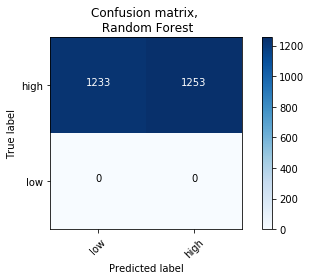

In [34]:
pred_rf = clf_rf.predict(X_test)
cnf_matrix = confusion_matrix(y_test, pred_rf)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['low', 'high'],
                      title='Confusion matrix, \n Random Forest')

In [35]:
print(classification_report(y_test, pred_rf, target_names=['low', 'high']))

              precision    recall  f1-score   support

         low       0.00      0.00      0.00         0
        high       1.00      0.50      0.67      2486

    accuracy                           0.50      2486
   macro avg       0.50      0.25      0.34      2486
weighted avg       1.00      0.50      0.67      2486



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
# accuracy of model
accuracy_score(y_test, pred_rf)

0.50402252614642

In [37]:
print(f'The training score for Random Forest is: {(clf_rf.score(X_train, y_train)*100):.2f}%')

The training score for Random Forest is: 100.00%


In [38]:
print(f'The test score for Random Forest is: {(clf_rf.score(X_test,y_test)*100):.2f}%')

The test score for Random Forest is: 50.40%


## Random Forest w/ GridSearchCV

In [40]:
params_rf = {"n_estimators":[100, 200, 300], "criterion":["gini","entropy"], "max_depth":[2,3,5,7]}
clf_gs_rf = GridSearchCV(clf_rf, params_rf, cv=5, return_train_score=True)
clf_gs_rf.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [41]:
rf_params = clf_gs_rf.cv_results_['params'][clf_gs_rf.best_index_]
rf_params

{'criterion': 'entropy', 'max_depth': 7, 'n_estimators': 200}

In [42]:
clf_rf_opt = RandomForestClassifier(criterion=rf_params["criterion"], max_depth=rf_params["max_depth"], n_estimators=rf_params["n_estimators"])
clf_rf_opt = clf_rf_opt.fit(X_train, y_train.values.ravel())
pred_rf_opt = clf_rf_opt.predict(X_test)

In [43]:
print(f'The training score for Random Forest is: {(clf_rf_opt.score(X_train, y_train)*100):.2f}%')
print(f'The test score for Random Forest is: {(clf_rf_opt.score(X_test,y_test)*100):.2f}%')

The training score for Random Forest is: 99.00%
The test score for Random Forest is: 49.56%


<Figure size 432x288 with 0 Axes>

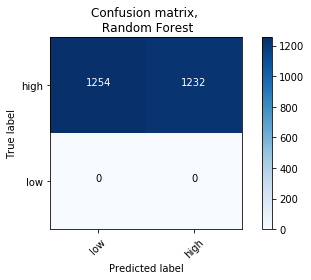

In [44]:
cnf_matrix = confusion_matrix(y_test, pred_rf_opt)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['low', 'high'],
                      title='Confusion matrix, \n Random Forest')

In [45]:
print(classification_report(y_test, pred_rf_opt, target_names=['low', 'high']))

              precision    recall  f1-score   support

         low       0.00      0.00      0.00         0
        high       1.00      0.50      0.66      2486

    accuracy                           0.50      2486
   macro avg       0.50      0.25      0.33      2486
weighted avg       1.00      0.50      0.66      2486



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Neural Net

In [46]:
# data_train_mm = scl_min_max.transform(X_train)
# data_test_mm = scl_min_max.transform(X_test)
# data_train_mm.shape

In [47]:
clf_nn = MLPClassifier(hidden_layer_sizes=(30,30,30,), early_stopping=False, learning_rate='adaptive', max_iter=1000)
clf_nn = clf_nn.fit(X_train, y_train.values.ravel())
pred_nn = clf_nn.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [75]:
print(f'The training score for Neural Net is: {(clf_nn.score(X_train, y_train)*100):.2f}%')
print(f'The test score for Neural Net is: {(clf_nn.score(X_test,y_test)*100):.2f}%')

The training score for Neural Net is: 78.60%
The test score for Neural Net is: 73.05%


## Cross Validation

In [76]:
clf_nb = MultinomialNB()

In [50]:
# CV=10
nb_cv_train_scores = cross_val_score(clf_nb, X_train, y_train.values.ravel(), cv=10)
print("k-fold: Cross-validation scores with k-fold splitter: \n{}".format(nb_cv_train_scores))

k-fold: Cross-validation scores with k-fold splitter: 
[0.7  0.46 0.56 0.48 0.5  0.62 0.52 0.66 0.68 0.74]


In [51]:
print("Accuracy: %0.2f (+/- %0.2f)" % (nb_cv_train_scores.mean(), nb_cv_train_scores.std() * 2))

Accuracy: 0.59 (+/- 0.19)


In [52]:
nb_cv_pred = cross_val_predict(clf_nb, X_train, y_train.values.ravel(), cv=10)

In [53]:
accuracy_score(y_train, nb_cv_pred)

0.592

## Cross Validation splitter

In [54]:
kfold_splitter = KFold (n_splits = 5)
cv_scores_kfold = cross_val_score(clf_rf_opt, X_train, y_train.values.ravel(), cv=kfold_splitter)

In [55]:
print("k-fold: Cross-validation scores with k-fold splitter: \n{}".format(cv_scores_kfold))

k-fold: Cross-validation scores with k-fold splitter: 
[0.91 0.9  0.96 0.88 0.91]


In [56]:
print("Accuracy: %0.2f (+/- %0.2f)" % (cv_scores_kfold.mean(), cv_scores_kfold.std() * 2))

Accuracy: 0.91 (+/- 0.05)


In [57]:
kfold_cv_pred = cross_val_predict(clf_rf_opt, X_train, y_train.values.ravel(), cv=kfold_splitter)
accuracy_score(y_train, kfold_cv_pred)

0.916

In [58]:
kfold_cv_pred = cross_val_predict(clf_rf_opt, X_test, y_test.values.ravel(), cv=kfold_splitter)
accuracy_score(y_test, kfold_cv_pred)

1.0

## Logistic Regression

In [59]:
clf_log = LogisticRegression()
clf_log = clf_log.fit(X_train, y_train.values.ravel())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [60]:
pred_log = clf_log.predict(X_test)

In [61]:
print(f'The training score for Logistic Regression is: {(clf_log.score(X_train, y_train)*100):.2f}%')
print(f'The test score for Logistic Regression is: {(clf_log.score(X_test,y_test)*100):.2f}%')

The training score for Logistic Regression is: 71.20%
The test score for Logistic Regression is: 70.39%


In [62]:
# accuracy of model
accuracy_score(y_test, pred_log)

0.7039420756234915

## Boosting

In [63]:
bagging = BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5)
bagging = bagging.fit(X_train, y_train.values.ravel())

In [64]:
bagging_pred = bagging.predict(X_test)
accuracy_score(y_test, bagging_pred)

0.4899436846339501

## ExtraTrees Classifier

In [65]:
et = ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
et = et.fit(X_train, y_train.values.ravel())

In [66]:
et_pred = et.predict(X_test)
accuracy_score(y_test, et_pred)

0.4923572003218021

## AdaBoost Classifier

In [67]:
ada = AdaBoostClassifier(n_estimators=100)
ada = ada.fit(X_train, y_train.values.ravel())

In [68]:
ada_pred = ada.predict(X_test)
accuracy_score(y_test, ada_pred)

0.502815768302494

## GradientBoostingClassifier

In [69]:
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
gbc = gbc.fit(X_train, y_train.values.ravel())

In [70]:
gbc_pred = gbc.predict(X_test)
accuracy_score(y_test, gbc_pred)

0.498390989541432

## Voting

In [71]:
vote_clf_hard = VotingClassifier(estimators=[('bagging', bagging),('rf', clf_rf_opt),('et',et),('ada',ada),('gbc',gbc)], voting='hard')
vote_clf_hard = vote_clf_hard.fit(X_train, y_train.values.ravel())

In [72]:
vote_clf_hard_pred = vote_clf_hard.predict(X_test)
accuracy_score(y_test, vote_clf_hard_pred)

0.4919549477071601

In [73]:
vote_clf_soft = VotingClassifier(estimators=[('bagging', bagging),('rf', clf_gs_rf),('et',et),('ada',ada),('gbc',gbc)], voting='soft', weights=[3,2,2,1,1])
vote_clf_soft = vote_clf_soft.fit(X_train, y_train.values.ravel())

In [74]:
vote_clf_soft = vote_clf_soft.predict(X_test)
accuracy_score(y_test, vote_clf_soft)

0.50201126307321

## Submission Process

In [ ]:
# Y_pred = clf_dt.predict(X_test)
# Y_pred

In [ ]:
ID = np.array(X_test['ID'].astype('int64'))
ID

In [ ]:
submission = pd.DataFrame([ID, pred_log])
submission = submission.T
submission.rename(columns={0:'ID', 1:'COVID_TCPM'}, inplace=True)
submission

In [ ]:
submission.to_csv('submission_LR.csv', index=False)

In [ ]:
sub_format